In [2]:
print(__doc__)
# author: Gael Varoquaux <gael.varoquaux@inria.fr>
# License: BSD 3 clause
# Copyright: INRIA

import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, graphical_lasso, GraphicalLasso
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.utils.extmath import fast_logdet


Automatically created module for IPython interactive environment


In [ ]:
# #############################################################################
# Generate the data
# Generate the data
n_samples = 500
n_features =300

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=prng)


#prec = np.identity(n_features)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
random_noise = np.random.normal(0, 1, n_samples*n_features).reshape(n_samples,n_features)

X = X + random_noise
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [63]:
#Empirical 
emp_cov = np.cov(X.T, bias=1)
emp_prec = linalg.inv(emp_cov)

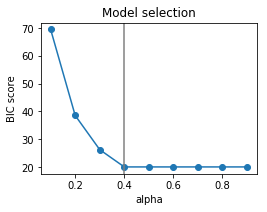

In [56]:

#BIC for different alpha 
alpha_array = np.arange(0.1, 1, 0.1) # model.cv_alphas_ #  
bic = []
k_bic_array = []
log_likelihood_gaus= []
off_diag_nz_array = []
for alpha in alpha_array:
    
    g = graphical_lasso(emp_cov, alpha, return_costs=True)
    
    prec_g = g[1]
    off_diag_nz =  2*np.sum(abs(np.triu(prec_g, k=1))) #==(np.abs(prec_g).sum()- np.abs(np.diag(prec_g)).sum()) 
    off_diag_nz_array.append(off_diag_nz)
    
    log_likelihood_g = ( - np.sum(emp_cov * prec_g) + fast_logdet(prec_g) )/2
    log_likelihood_gaus.append(log_likelihood_g)
    

    k_bic = np.count_nonzero(np.triu(prec_g, k=1)) #upper triangle w/o diag
   
    #k_bic_wrong = np.count_nonzero(np.triu(prec_g, k=0)) #WRONG
    
    k_bic_array.append(k_bic)
                       
    bic.append( -2*log_likelihood_g + (k_bic) * np.log(X.shape[0]))
 
        
#pick the smallest BIC
alpha_bic = alpha_array[np.argmin(bic)]
g_bic = graphical_lasso(emp_cov, alpha=alpha_bic)
bic_prec = g_bic[1]
bic_cov = g_bic[0]


# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(alpha_array, bic, 'o-')
plt.axvline(alpha_bic, color='.5')
plt.title('Model selection')
plt.ylabel('BIC score')
plt.xlabel('alpha')

plt.show()

# r = alpha_array * off_diag_nz_array
# # plot the model selection metric
# plt.figure(figsize=(4, 3))
# plt.axes([.2, .15, .75, .7])
# plt.plot(alpha_array, r, 'o-')
# plt.axvline(alpha_bic, color='.5')
# plt.title('')
# plt.ylabel('alpha*off_daiag_nz')
# plt.xlabel('alpha')

# plt.show()


# # plot the model selection metric
# plt.figure(figsize=(4, 3))
# plt.axes([.2, .15, .75, .7])
# plt.plot(alpha_array, off_diag_nz_array, 'o-')
# plt.axvline(alpha_bic, color='.5')
# plt.title('')
# plt.ylabel('off_daig_nz')
# plt.xlabel('alpha')

# plt.show()





# # plot the model selection metric
# plt.figure(figsize=(4, 3))
# plt.axes([.2, .15, .75, .7])
# plt.plot(alpha_array, k_bic_array, 'o-')
# plt.axvline(alpha_bic, color='.5')
# plt.title('')
# plt.ylabel(' k_bic')
# plt.xlabel('alpha')

# plt.show()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py:1965: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


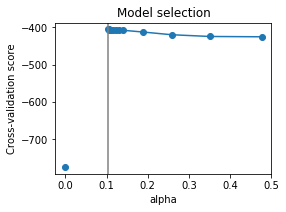

In [64]:
# #############################################################################
# Estimate the covariance
emp_cov = np.dot(X.T, X) / n_samples

model = GraphicalLassoCV(cv=5)
model.fit(X)
cv_cov = model.covariance_
cv_prec = model.precision_

# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(model.cv_alphas_, np.mean(model.grid_scores_, axis=1), 'o-')
plt.axvline(model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()

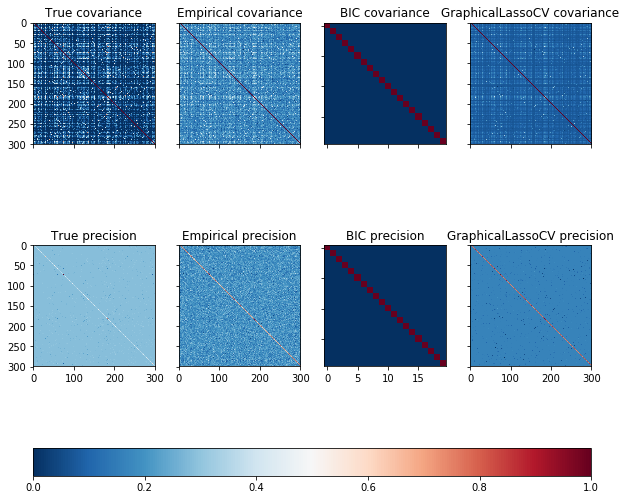

In [65]:

Nr = 2
Nc = 4
cmap = plt.cm.RdBu_r

fig, axs = plt.subplots(Nr, Nc, figsize=(10,10))
#fig.suptitle('Multiple images')

# plot the covariances
covs_precs = [('Empirical', emp_cov), ('BIC', bic_cov),
        ('GraphicalLassoCV', cv_cov), ('True', cov), ('Empirical', emp_prec), ('BIC', bic_prec),
         ('GraphicalLasso', cv_prec), ('True', prec)]


covs_precs = [ cov, emp_cov, bic_cov, cv_cov, prec, emp_prec, bic_prec, cv_prec]

names= ['True covariance', 'Empirical covariance', 'BIC covariance', 'GraphicalLassoCV covariance', 'True precision', 'Empirical precision', 'BIC precision', 'GraphicalLassoCV precision' ]

images = []
k = 0
for i in range(Nr):
    for j in range(Nc):
        data = covs_precs[k]
        images.append(axs[i, j].imshow(data, cmap=cmap))
        axs[i, j].label_outer()
        #plt.xticks(())
        #plt.yticks(())
        title = names[k]
        axs[i, j].set_title(title)
        k +=1 
 
# # Find the min and max of all colors for use in setting the color scale.
# vmin = min(image.get_array().min() for image in images)
# vmax = max(image.get_array().max() for image in images)
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# for im in images:
#     im.set_norm(norm)

fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)


# # Make images respond to changes in the norm of other images (e.g. via the
# # "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# # recurse infinitely!
# def update(changed_image):
#     for im in images:
#         if (changed_image.get_cmap() != im.get_cmap()
#                 or changed_image.get_clim() != im.get_clim()):
#             im.set_cmap(changed_image.get_cmap())
#             im.set_clim(changed_image.get_clim())


# for im in images:
#     im.callbacksSM.connect('changed', update)

plt.show()       